In [1]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb

In [2]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
import optuna
from optuna import Trial
from optuna import create_study
from optuna import pruners
from optuna.pruners import SuccessiveHalvingPruner
from optuna import samplers
from optuna.samplers import TPESampler
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances

In [3]:
#import all the function we built during feature selection which may come in handy here 
from src.utils.HPT_utils import *

In [4]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from mlflow import pyfunc

In [5]:
from pathlib import Path

# After feature selection for the training set with the three encodings we chose using our baseline CatBoostClassifier model, we're going to tune the hyperparameters of various models including CatBoostClassifier and other ensemble methods using Optuna and see if we can improve the baseline results.

<font size=4>First, we import the training and the test sets with the three encoding we chose: no encoding, double MEstimate encoding and mixed one-hot and CatBoost encoding.</font>

In [6]:
# No encoding
df_train_NE = pd.read_csv("../data/feature-selected/unencoded/train.csv")
df_test_NE = pd.read_csv("../data/feature-selected/unencoded/test.csv")
# Double MEstimate 
df_train_ME = pd.read_csv("../data/feature-selected/MEstimate/train.csv")
df_test_ME = pd.read_csv("../data/feature-selected/MEstimate/test.csv")
# Mixed One-Hot and CatBoost 
df_train_Mixed = pd.read_csv("../data/feature-selected/Mixed/train.csv")
df_test_Mixed = pd.read_csv("../data/feature-selected/Mixed/test.csv")

<a id="1"></a>
# 1 **Baseline CatBoostClassifier, and more baseline ensemble models**

<a id="1.1"></a>
## 1.1 **CatBoostClassifier**

In [24]:
base_params = {'verbose': False, 'eval_metric': 'Accuracy'}

<a id="1.1.1"></a>
### 1.1.1 **No encoding**

In [5]:
base_fit_kwargs_NE = get_fit_cat_params(CatBoostClassifier.__name__, cat_col_list=get_cat_features(df_train_NE, 'Transported'))

In [8]:
base_CatBoost_NE= cv_training(estimator=CatBoostClassifier, params= base_params, n_splits = 10)

Starting the fitting process.
Starting training for fold 1
Completed training for fold 1
Starting training for fold 2
Completed training for fold 2
Starting training for fold 3
Completed training for fold 3
Starting training for fold 4
Completed training for fold 4
Starting training for fold 5
Completed training for fold 5
Starting training for fold 6
Completed training for fold 6
Starting training for fold 7
Completed training for fold 7
Starting training for fold 8
Completed training for fold 8
Starting training for fold 9
Completed training for fold 9
Starting training for fold 10
Completed training for fold 10
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The metric scores in all cv folds for accuracy are [0.7979214780600462, 0.8094688221709007, 0.7990762124711316, 0.8060046189376443, 0.8140877598152425, 0.8060046189376443, 0.7990762124711316, 0.8198614318706697, 0.8094688221709007, 0.8023121387283237]. 
 The final score is 0.8

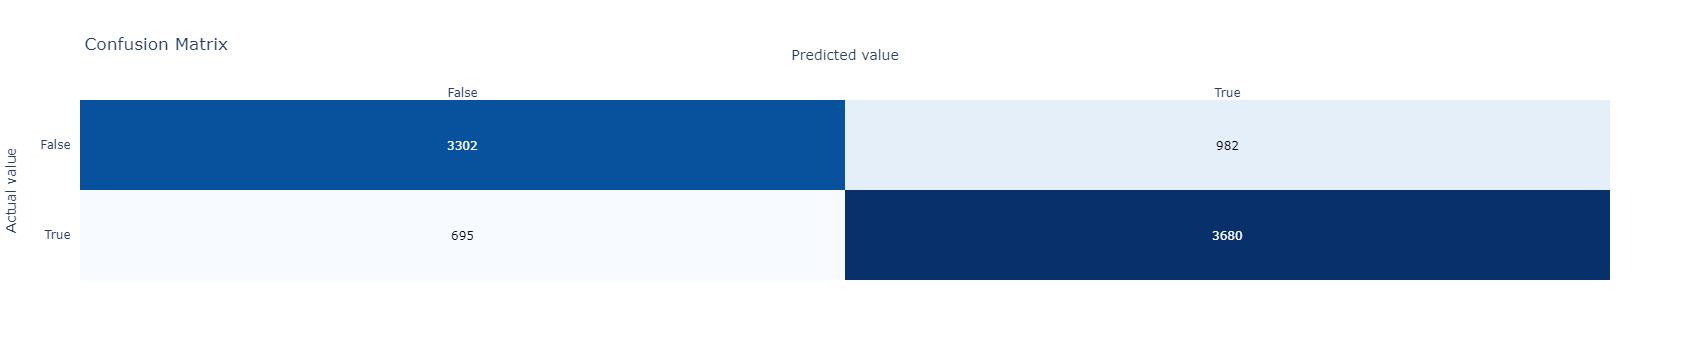

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The metric scores in all cv folds for confusion_matrix are [array([[340,  89],
       [ 86, 351]]), array([[343,  91],
       [ 74, 358]]), array([[336, 112],
       [ 62, 356]]), array([[337,  94],
       [ 74, 361]]), array([[325, 109],
       [ 52, 380]]), array([[318,  90],
       [ 78, 380]]), array([[340, 106],
       [ 68, 352]]), array([[309,  77],
       [ 79, 401]]), array([[342, 107],
       [ 58, 359]]), array([[312, 107],
       [ 64, 382]])]. 
 The final score is [[3302  982]
 [ 695 3680]], and the standard deviation is 134.26261346704078
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


cv_training(estimator=<class 'catboost.core.CatBoostClassifier'>,
            params={'eval_metric': 'Accuracy', 'verbose': False})

In [9]:
base_CatBoost_NE.fit(df_train_NE, label="Transported", fit_kwargs=base_fit_kwargs_NE, metric_list=["accuracy", "roc_auc", "f1", "confusion_matrix"], metric_opt_dir_list=["max", "max","max", "compr"])

<font size=4>We see the final accuracy score for baseline CatBoostClassifier without prior encoding is 0.8060046189376443, and the standard deviation is 0.006747443413546501.</font>

<a id="1.1.2"></a>
### 1.1.2 **MEstimate**

In [17]:
base_fit_kwargs_ME = get_fit_cat_params(CatBoostClassifier.__name__, cat_col_list=get_cat_features(df_train_ME, 'Transported'))

In [18]:
base_CatBoost_ME= cv_training(estimator=CatBoostClassifier, params= base_params, n_splits = 10)

Starting the fitting process.
Starting training for fold 1
Completed training for fold 1
Starting training for fold 2
Completed training for fold 2
Starting training for fold 3
Completed training for fold 3
Starting training for fold 4
Completed training for fold 4
Starting training for fold 5
Completed training for fold 5
Starting training for fold 6
Completed training for fold 6
Starting training for fold 7
Completed training for fold 7
Starting training for fold 8
Completed training for fold 8
Starting training for fold 9
Completed training for fold 9
Starting training for fold 10
Completed training for fold 10
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The metric scores in all cv folds for accuracy are [0.7875288683602771, 0.8071593533487298, 0.7979214780600462, 0.8071593533487298, 0.8106235565819861, 0.8117782909930716, 0.8025404157043879, 0.8175519630484989, 0.8036951501154734, 0.8057803468208092]. 
 The final score is 0.8

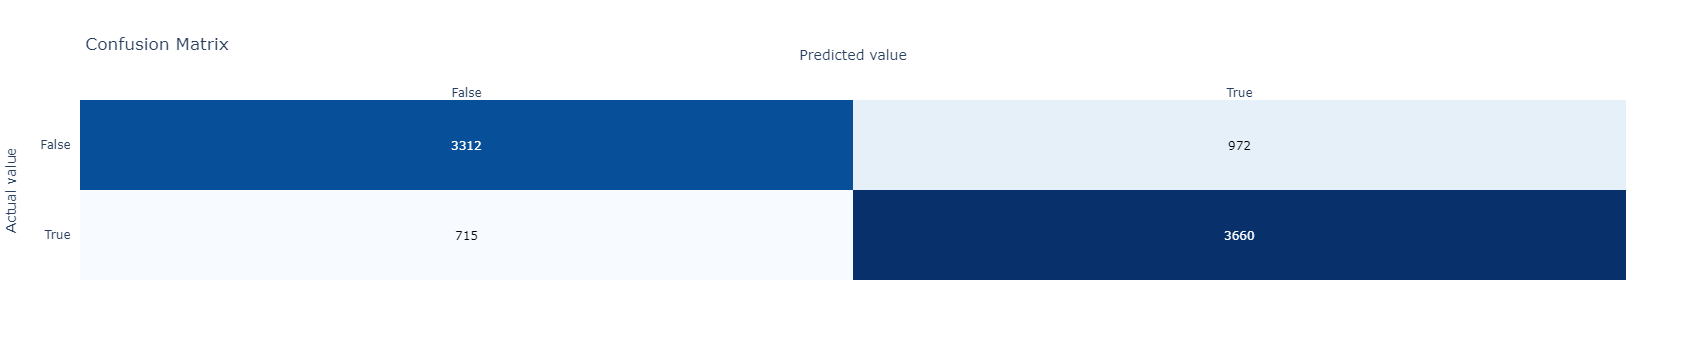

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The metric scores in all cv folds for confusion_matrix are [array([[336,  93],
       [ 91, 346]]), array([[343,  91],
       [ 76, 356]]), array([[335, 113],
       [ 62, 356]]), array([[338,  93],
       [ 74, 361]]), array([[335,  99],
       [ 65, 367]]), array([[317,  91],
       [ 72, 386]]), array([[344, 102],
       [ 69, 351]]), array([[311,  75],
       [ 83, 397]]), array([[339, 110],
       [ 60, 357]]), array([[314, 105],
       [ 63, 383]])]. 
 The final score is [[3312  972]
 [ 715 3660]], and the standard deviation is 133.56421442512212
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


cv_training(estimator=<class 'catboost.core.CatBoostClassifier'>,
            params={'eval_metric': 'Accuracy', 'verbose': False})

In [19]:
base_CatBoost_ME.fit(df_train_ME, label="Transported", fit_kwargs=base_fit_kwargs_ME, metric_list=["accuracy", "roc_auc", "f1", "confusion_matrix"], metric_opt_dir_list=["max", "max","max", "compr"])

<font size=4>We see the final accuracy score for baseline CatBoostClassifier with MEstimate encoding is 0.8051738776382009, and the standard deviation is 0.00779648456769565.</font>

<a id="1.1.3"></a>
### 1.1.3 **Mixed OHE and CatBoost encoding**

In [20]:
base_fit_kwargs_Mixed = get_fit_cat_params(CatBoostClassifier.__name__, cat_col_list=get_cat_features(df_train_Mixed, 'Transported'))

In [21]:
base_CatBoost_Mixed= cv_training(estimator=CatBoostClassifier, params= base_params, n_splits = 10)

Starting the fitting process.
Starting training for fold 1
Completed training for fold 1
Starting training for fold 2
Completed training for fold 2
Starting training for fold 3
Completed training for fold 3
Starting training for fold 4
Completed training for fold 4
Starting training for fold 5
Completed training for fold 5
Starting training for fold 6
Completed training for fold 6
Starting training for fold 7
Completed training for fold 7
Starting training for fold 8
Completed training for fold 8
Starting training for fold 9
Completed training for fold 9
Starting training for fold 10
Completed training for fold 10
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The metric scores in all cv folds for accuracy are [0.8002309468822171, 0.8094688221709007, 0.7967667436489607, 0.8025404157043879, 0.8106235565819861, 0.8071593533487298, 0.8083140877598153, 0.8140877598152425, 0.815242494226328, 0.7988439306358381]. 
 The final score is 0.80

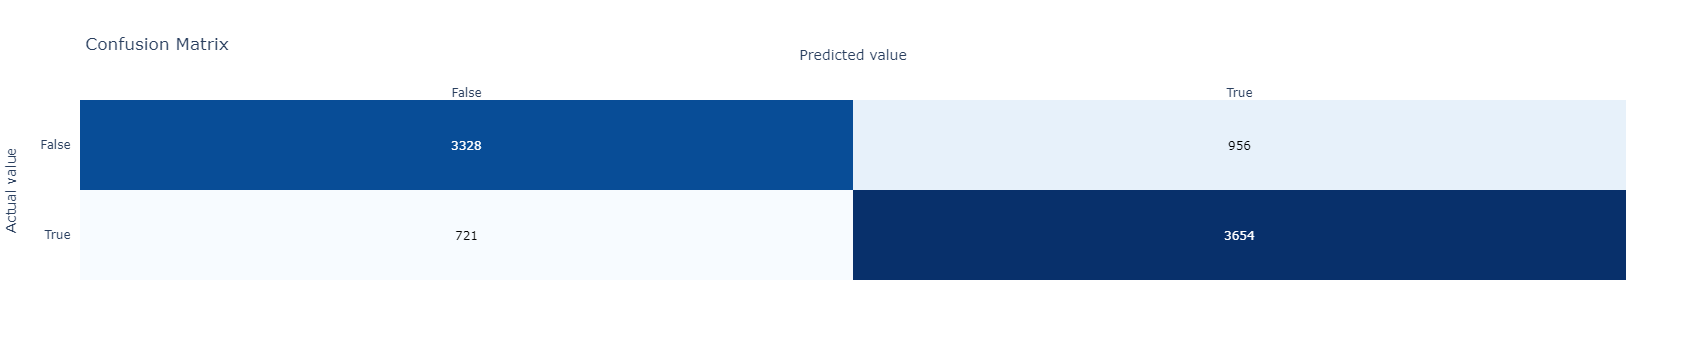

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The metric scores in all cv folds for confusion_matrix are [array([[337,  92],
       [ 81, 356]]), array([[340,  94],
       [ 71, 361]]), array([[338, 110],
       [ 66, 352]]), array([[337,  94],
       [ 77, 358]]), array([[333, 101],
       [ 63, 369]]), array([[321,  87],
       [ 80, 378]]), array([[349,  97],
       [ 69, 351]]), array([[310,  76],
       [ 85, 395]]), array([[352,  97],
       [ 63, 354]]), array([[311, 108],
       [ 66, 380]])]. 
 The final score is [[3328  956]
 [ 721 3654]], and the standard deviation is 133.87718018766304
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


cv_training(estimator=<class 'catboost.core.CatBoostClassifier'>,
            params={'eval_metric': 'Accuracy', 'verbose': False})

In [22]:
base_CatBoost_Mixed.fit(df_train_Mixed, label="Transported", fit_kwargs=base_fit_kwargs_Mixed, metric_list=["accuracy", "roc_auc", "f1", "confusion_matrix"], metric_opt_dir_list=["max", "max","max", "compr"])

<font size=4>We see the final accuracy score for baseline CatBoostClassifier with Mixed OHE and CatBoost encoding is 0.8063278110774406, and the standard deviation is 0.006095761735487017  </font>

<a id="1.2"></a>
## 1.2 **ExtraTreesClassifier**

In [25]:
base_params_ET = {'n_jobs': -1, 'random_state': 42}

<font size=4>ExtraTreesClassifier do not support a training set without encoding, so we skip the no-encoding case.</font>

<a id="1.2.1"></a>
### 1.2.1 **MEstimate**

In [32]:
base_ExtraTrees_ME= cv_training(estimator=ExtraTreesClassifier, params= base_params_ET, n_splits = 10)

Starting the fitting process.
Starting training for fold 1
Completed training for fold 1
Starting training for fold 2
Completed training for fold 2
Starting training for fold 3
Completed training for fold 3
Starting training for fold 4
Completed training for fold 4
Starting training for fold 5
Completed training for fold 5
Starting training for fold 6
Completed training for fold 6
Starting training for fold 7
Completed training for fold 7
Starting training for fold 8
Completed training for fold 8
Starting training for fold 9
Completed training for fold 9
Starting training for fold 10
Completed training for fold 10
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The metric scores in all cv folds for accuracy are [0.7886836027713626, 0.7909930715935335, 0.7875288683602771, 0.7806004618937644, 0.792147806004619, 0.8025404157043879, 0.7990762124711316, 0.8036951501154734, 0.792147806004619, 0.7884393063583816]. 
 The final score is 0.791

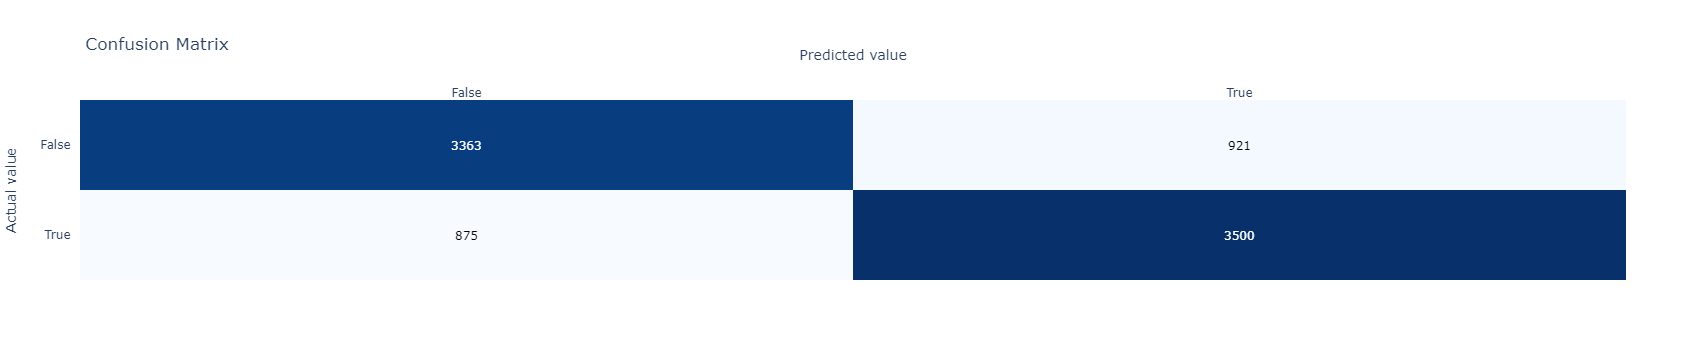

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The metric scores in all cv folds for confusion_matrix are [array([[340,  89],
       [ 94, 343]]), array([[339,  95],
       [ 86, 346]]), array([[347, 101],
       [ 83, 335]]), array([[341,  90],
       [100, 335]]), array([[335,  99],
       [ 81, 351]]), array([[328,  80],
       [ 91, 367]]), array([[354,  92],
       [ 82, 338]]), array([[315,  71],
       [ 99, 381]]), array([[344, 105],
       [ 75, 342]]), array([[320,  99],
       [ 84, 362]])]. 
 The final score is [[3363  921]
 [ 875 3500]], and the standard deviation is 127.26998615148821
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


cv_training(estimator=<class 'sklearn.ensemble._forest.ExtraTreesClassifier'>,
            params={'n_jobs': -1, 'random_state': 42})

In [33]:
base_ExtraTrees_ME.fit(df_train_ME, label="Transported", metric_list=["accuracy", "roc_auc", "f1", "confusion_matrix"], metric_opt_dir_list=["max", "max","max", "compr"])

<font size=4>We see the final accuracy score for baseline ExtraTreesClassifier with MEstimate encoding is 0.7915704387990763, and the standard deviation is 0.0068498130351529775. </font>

<a id="1.2.2"></a>
### 1.2.2 **Mixed OHE and CatBoost encoding**

In [34]:
base_ExtraTrees_Mixed= cv_training(estimator=ExtraTreesClassifier, params= base_params_ET, n_splits = 10)

Starting the fitting process.
Starting training for fold 1
Completed training for fold 1
Starting training for fold 2
Completed training for fold 2
Starting training for fold 3
Completed training for fold 3
Starting training for fold 4
Completed training for fold 4
Starting training for fold 5
Completed training for fold 5
Starting training for fold 6
Completed training for fold 6
Starting training for fold 7
Completed training for fold 7
Starting training for fold 8
Completed training for fold 8
Starting training for fold 9
Completed training for fold 9
Starting training for fold 10
Completed training for fold 10
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The metric scores in all cv folds for accuracy are [0.792147806004619, 0.7852193995381063, 0.7863741339491916, 0.8060046189376443, 0.8002309468822171, 0.8036951501154734, 0.789838337182448, 0.8036951501154734, 0.7933025404157044, 0.7953757225433526]. 
 The final score is 0.794

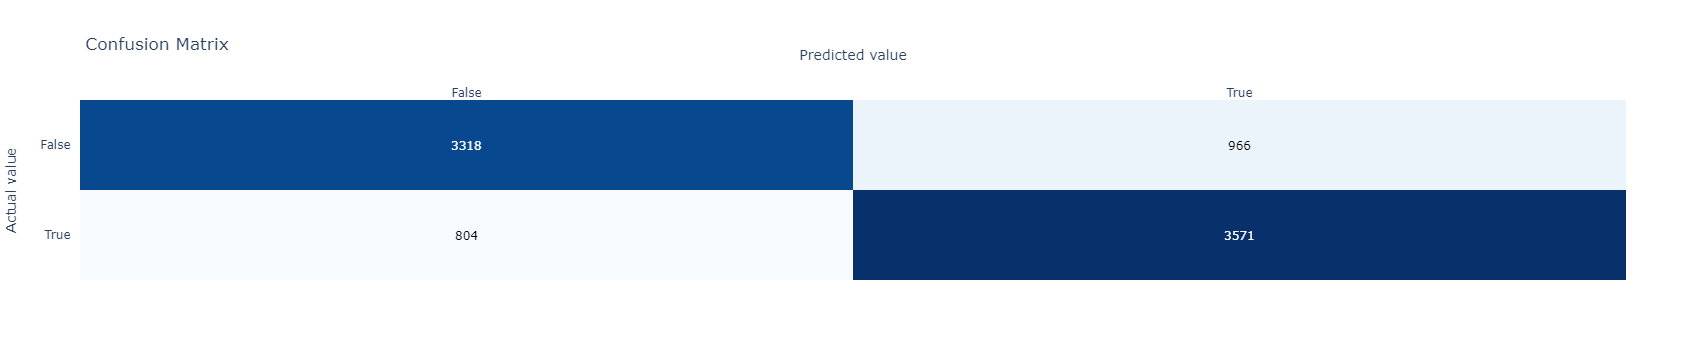

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The metric scores in all cv folds for confusion_matrix are [array([[338,  91],
       [ 89, 348]]), array([[333, 101],
       [ 85, 347]]), array([[343, 105],
       [ 80, 338]]), array([[347,  84],
       [ 84, 351]]), array([[332, 102],
       [ 71, 361]]), array([[317,  91],
       [ 79, 379]]), array([[344, 102],
       [ 80, 340]]), array([[312,  74],
       [ 96, 384]]), array([[338, 111],
       [ 68, 349]]), array([[314, 105],
       [ 72, 374]])]. 
 The final score is [[3318  966]
 [ 804 3571]], and the standard deviation is 128.97693349975413
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


cv_training(estimator=<class 'sklearn.ensemble._forest.ExtraTreesClassifier'>,
            params={'n_jobs': -1, 'random_state': 42})

In [35]:
base_ExtraTrees_Mixed.fit(df_train_Mixed, label="Transported", metric_list=["accuracy", "roc_auc", "f1", "confusion_matrix"], metric_opt_dir_list=["max", "max","max", "compr"])

<font size=4>We see the final accuracy score for baseline ExtraTreesClassifier with MEstimate encoding is 0.7943391314795285, and the standard deviation is 0.007099857871792677.  </font>

<a id="1.3"></a>
## 1.3 **HistGradientBoostingClassifier**

In [36]:
base_params_HGB = {'random_state': 42}

<a id="1.3.1"></a>
### 1.3.1 **No encoding**

In [38]:
base_fit_kwargs_HGB_NE = get_fit_cat_params(HistGradientBoostingClassifier.__name__, cat_col_list=get_cat_features(df_train_NE, 'Transported'))

In [49]:
base_params_HGB_NE = {**base_fit_kwargs_HGB_NE, **base_params_HGB}

In [51]:
base_HistGradientBoosting_NE= cv_training(estimator=HistGradientBoostingClassifier, params= base_params_HGB_NE, n_splits = 10)

Starting the fitting process.
Starting training for fold 1
Completed training for fold 1
Starting training for fold 2
Completed training for fold 2
Starting training for fold 3
Completed training for fold 3
Starting training for fold 4
Completed training for fold 4
Starting training for fold 5
Completed training for fold 5
Starting training for fold 6
Completed training for fold 6
Starting training for fold 7
Completed training for fold 7
Starting training for fold 8
Completed training for fold 8
Starting training for fold 9
Completed training for fold 9
Starting training for fold 10
Completed training for fold 10
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The metric scores in all cv folds for accuracy are [0.8013856812933026, 0.8002309468822171, 0.7967667436489607, 0.7956120092378753, 0.8060046189376443, 0.8083140877598153, 0.8013856812933026, 0.812933025404157, 0.7956120092378753, 0.8023121387283237]. 
 The final score is 0.80

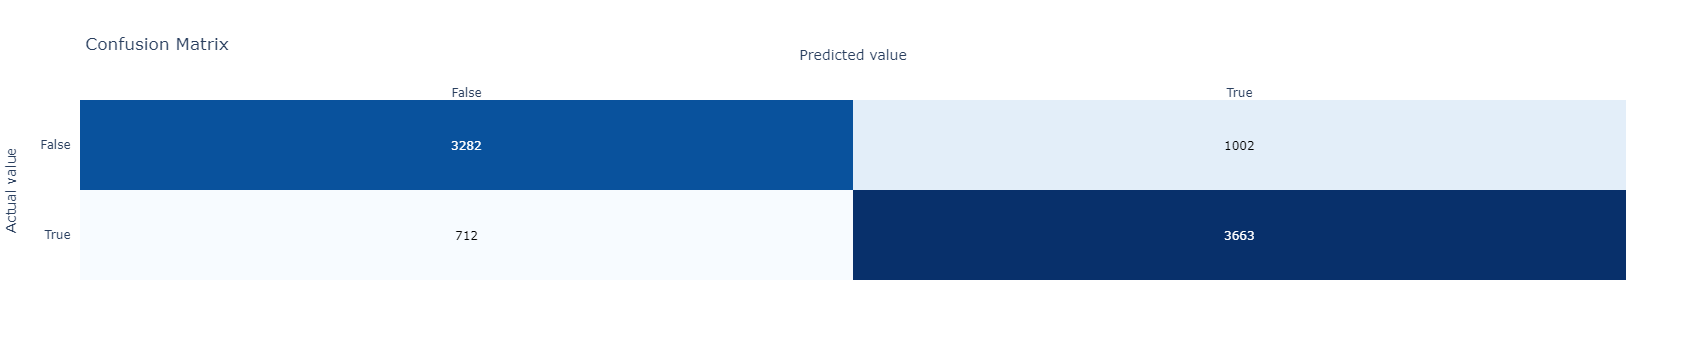

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The metric scores in all cv folds for confusion_matrix are [array([[340,  89],
       [ 83, 354]]), array([[334, 100],
       [ 73, 359]]), array([[333, 115],
       [ 61, 357]]), array([[336,  95],
       [ 82, 353]]), array([[319, 115],
       [ 53, 379]]), array([[316,  92],
       [ 74, 384]]), array([[347,  99],
       [ 73, 347]]), array([[309,  77],
       [ 85, 395]]), array([[338, 111],
       [ 66, 351]]), array([[310, 109],
       [ 62, 384]])]. 
 The final score is [[3282 1002]
 [ 712 3663]], and the standard deviation is 132.50207309698968
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


cv_training(estimator=<class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier'>,
            params={'categorical_features': ['CryoSleep', 'Destination', 'VIP',
                                             'Cabin_deck', 'HomePlanet',
                                             'Age_group'],
                    'random_state': 42})

In [52]:
base_HistGradientBoosting_NE.fit(df_train_NE, label="Transported", metric_list=["accuracy", "roc_auc", "f1", "confusion_matrix"], metric_opt_dir_list=["max", "max","max", "compr"])

<font size=4>We see the final accuracy score for baseline HistGradientBoostingClassifier without prior encoding is 0.8013856812933026, and the standard deviation is 0.005370160905706192.</font>

<a id="1.3.2"></a>
### 1.3.2 **MEstimate**

In [55]:
base_HistGradientBoosting_ME= cv_training(estimator=HistGradientBoostingClassifier, params= base_params_HGB, n_splits = 10)

Starting the fitting process.
Starting training for fold 1
Completed training for fold 1
Starting training for fold 2
Completed training for fold 2
Starting training for fold 3
Completed training for fold 3
Starting training for fold 4
Completed training for fold 4
Starting training for fold 5
Completed training for fold 5
Starting training for fold 6
Completed training for fold 6
Starting training for fold 7
Completed training for fold 7
Starting training for fold 8
Completed training for fold 8
Starting training for fold 9
Completed training for fold 9
Starting training for fold 10
Completed training for fold 10
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The metric scores in all cv folds for accuracy are [0.789838337182448, 0.8013856812933026, 0.7852193995381063, 0.7852193995381063, 0.8106235565819861, 0.8071593533487298, 0.7990762124711316, 0.8198614318706697, 0.7909930715935335, 0.793063583815029]. 
 The final score is 0.796

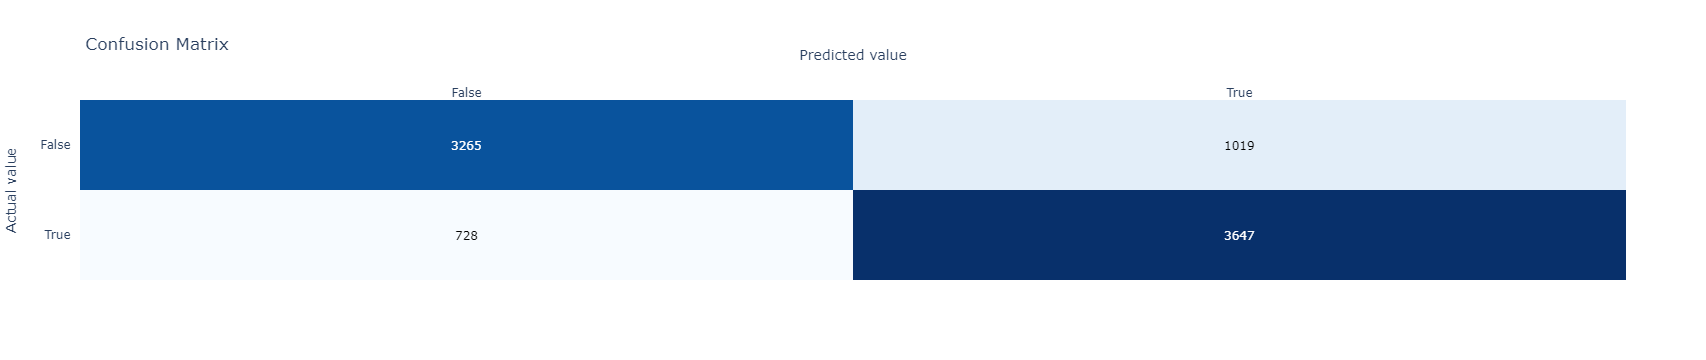

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The metric scores in all cv folds for confusion_matrix are [array([[338,  91],
       [ 91, 346]]), array([[337,  97],
       [ 75, 357]]), array([[334, 114],
       [ 72, 346]]), array([[328, 103],
       [ 83, 352]]), array([[332, 102],
       [ 62, 370]]), array([[311,  97],
       [ 70, 388]]), array([[338, 108],
       [ 66, 354]]), array([[310,  76],
       [ 80, 400]]), array([[339, 110],
       [ 71, 346]]), array([[298, 121],
       [ 58, 388]])]. 
 The final score is [[3265 1019]
 [ 728 3647]], and the standard deviation is 131.00457768719383
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


cv_training(estimator=<class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier'>,
            params={'random_state': 42})

In [56]:
base_HistGradientBoosting_ME.fit(df_train_ME, label="Transported", metric_list=["accuracy", "roc_auc", "f1", "confusion_matrix"], metric_opt_dir_list=["max", "max","max", "compr"])

<font size=4>We see the final accuracy score for baseline HistGradientBoostingClassifier without prior encoding is 0.7960698981430803, and the standard deviation is 0.010954274610943372.</font>

<a id="1.3.3"></a>
### 1.3.3 **Mixed OHE and CatBoost encoding**

In [57]:
base_fit_kwargs_HGB_Mixed = get_fit_cat_params(HistGradientBoostingClassifier.__name__, cat_col_list=get_cat_features(df_train_Mixed, 'Transported'))

In [58]:
base_params_HGB_Mixed = {**base_fit_kwargs_HGB_Mixed, **base_params_HGB}

In [59]:
base_HistGradientBoosting_Mixed= cv_training(estimator=HistGradientBoostingClassifier, params= base_params_HGB_Mixed, n_splits = 10)

Starting the fitting process.
Starting training for fold 1
Completed training for fold 1
Starting training for fold 2
Completed training for fold 2
Starting training for fold 3
Completed training for fold 3
Starting training for fold 4
Completed training for fold 4
Starting training for fold 5
Completed training for fold 5
Starting training for fold 6
Completed training for fold 6
Starting training for fold 7
Completed training for fold 7
Starting training for fold 8
Completed training for fold 8
Starting training for fold 9
Completed training for fold 9
Starting training for fold 10
Completed training for fold 10
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The metric scores in all cv folds for accuracy are [0.7956120092378753, 0.7990762124711316, 0.7990762124711316, 0.7944572748267898, 0.8071593533487298, 0.8106235565819861, 0.8013856812933026, 0.8140877598152425, 0.7967667436489607, 0.7942196531791907]. 
 The final score is 0.7

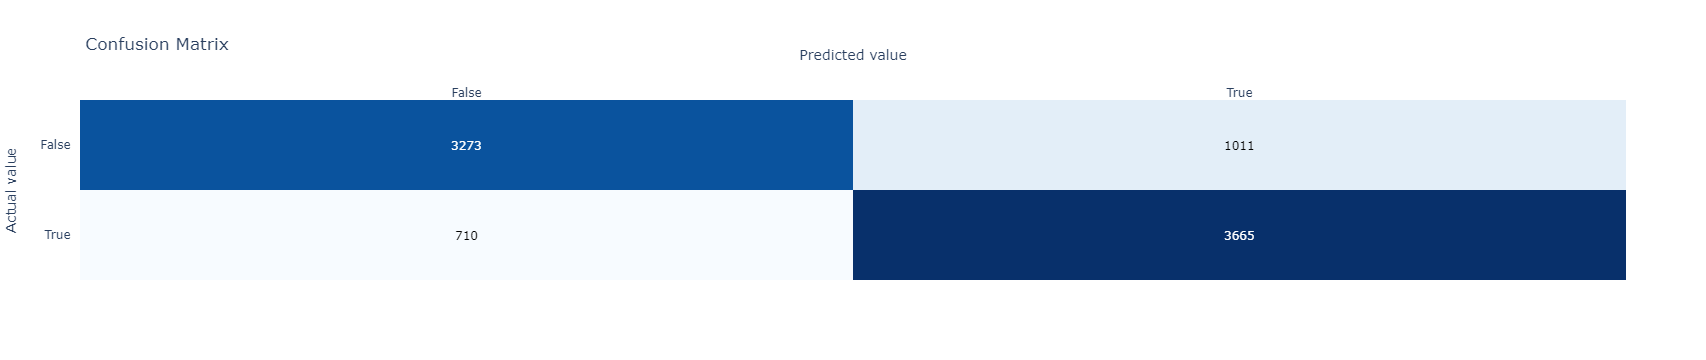

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The metric scores in all cv folds for confusion_matrix are [array([[339,  90],
       [ 87, 350]]), array([[335,  99],
       [ 75, 357]]), array([[339, 109],
       [ 65, 353]]), array([[328, 103],
       [ 75, 360]]), array([[330, 104],
       [ 63, 369]]), array([[309,  99],
       [ 65, 393]]), array([[347,  99],
       [ 73, 347]]), array([[309,  77],
       [ 84, 396]]), array([[336, 113],
       [ 63, 354]]), array([[301, 118],
       [ 60, 386]])]. 
 The final score is [[3273 1011]
 [ 710 3665]], and the standard deviation is 132.27716875938947
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


cv_training(estimator=<class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier'>,
            params={'categorical_features': [], 'random_state': 42})

In [61]:
base_HistGradientBoosting_Mixed.fit(df_train_Mixed, label="Transported", metric_list=["accuracy", "roc_auc", "f1", "confusion_matrix"], metric_opt_dir_list=["max", "max","max", "compr"])

<font size=4>We see the final accuracy score for baseline HistGradientBoostingClassifier without prior encoding is 0.7990762124711316, and the standard deviation is 0.0066671920898948136.</font>

<a id="1.4"></a>
## 1.4 **XGBClassifier**

In [66]:
base_params_XGB = {'random_state': 42, 'enable_categorical':True, 'eval_metriceval_metric': 'accuracy_score', 'n_jobs': -1}

In [71]:
def convert_object_to_category(df):
    """
    Convert all object type columns in a DataFrame to category type.
    
    Parameters:
        df (pd.DataFrame): The DataFrame to convert.
    
    Returns:
        pd.DataFrame: A DataFrame with object type columns converted to category type.
    """
    for column in df.select_dtypes(include=['object']).columns:
        df[column] = df[column].astype('category')
    return df

<a id="1.4.1"></a>
### 1.4.1 **No encoding**

In [72]:
df_train_NE = convert_object_to_category(df_train_NE)

In [73]:
base_XGBoost_NE= cv_training(estimator=xgb.XGBClassifier, params= base_params_XGB, n_splits = 10)

Starting the fitting process.
Starting training for fold 1


/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:34:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.




Completed training for fold 1
Starting training for fold 2


/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:34:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.




Completed training for fold 2
Starting training for fold 3


/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:34:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.




Completed training for fold 3
Starting training for fold 4


/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:34:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.




Completed training for fold 4
Starting training for fold 5
Completed training for fold 5
Starting training for fold 6


/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:34:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.


/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:34:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.




Completed training for fold 6
Starting training for fold 7


/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:34:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.




Completed training for fold 7
Starting training for fold 8
Completed training for fold 8
Starting training for fold 9


/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:34:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.


/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:34:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.




Completed training for fold 9
Starting training for fold 10
Completed training for fold 10
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The metric scores in all cv folds for accuracy are [0.789838337182448, 0.7933025404157044, 0.7817551963048499, 0.7886836027713626, 0.8036951501154734, 0.8002309468822171, 0.7875288683602771, 0.8117782909930716, 0.8002309468822171, 0.7953757225433526]. 
 The final score is 0.7943391314795285, and the standard deviation is 0.008438374568060786
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The metric scores in all cv folds for roc_auc are [0.7898844100217098, 0.7933254394947943, 0.78305493848257, 0.7886417580073071, 0.8038274449564773, 0.7986931672232213, 0.7878923766816144, 0.8106757340241796, 0.8023078196685414, 0.7934784935304001]. 
 The final 

/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:34:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.




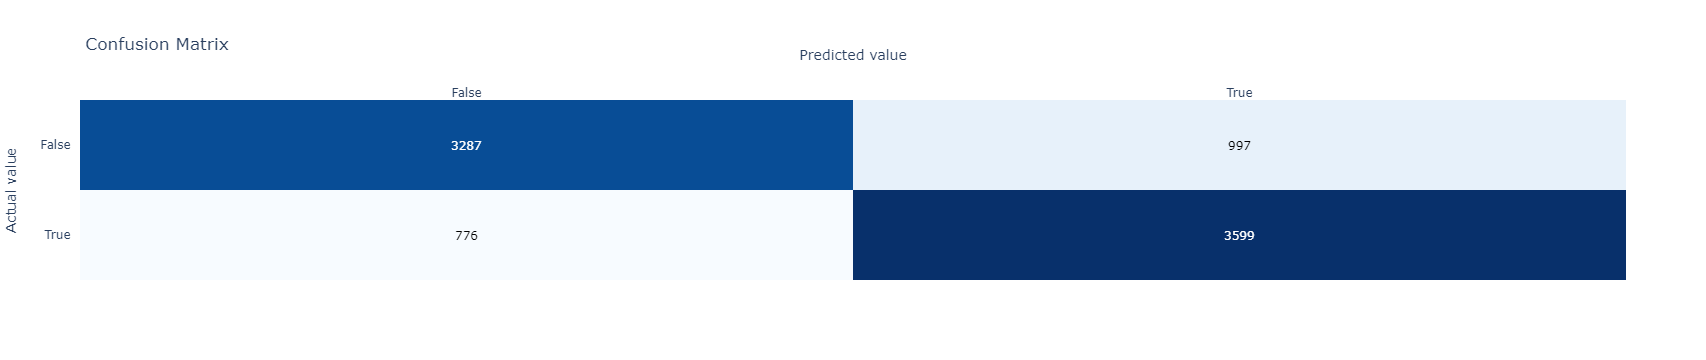

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The metric scores in all cv folds for confusion_matrix are [array([[341,  88],
       [ 94, 343]]), array([[340,  94],
       [ 85, 347]]), array([[334, 114],
       [ 75, 343]]), array([[336,  95],
       [ 88, 347]]), array([[324, 110],
       [ 60, 372]]), array([[315,  93],
       [ 80, 378]]), array([[346, 100],
       [ 84, 336]]), array([[309,  77],
       [ 86, 394]]), array([[335, 114],
       [ 59, 358]]), array([[307, 112],
       [ 65, 381]])]. 
 The final score is [[3287  997]
 [ 776 3599]], and the standard deviation is 129.32478252446435
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


cv_training(estimator=<class 'xgboost.sklearn.XGBClassifier'>,
            params={'enable_categorical': True,
                    'eval_metriceval_metric': 'accuracy_score', 'n_jobs': -1,
                    'random_state': 42})

In [74]:
base_XGBoost_NE.fit(df_train_NE, label="Transported", metric_list=["accuracy", "roc_auc", "f1", "confusion_matrix"], metric_opt_dir_list=["max", "max","max", "compr"])

<font size=4>We see the final accuracy score for baseline XGBClassifier without prior encoding is 0.7943391314795285, and the standard deviation is 0.008438374568060786.</font>

<a id="1.4.2"></a>
### 1.4.2 **MEstimate**

In [75]:
base_XGBoost_ME= cv_training(estimator=xgb.XGBClassifier, params= base_params_XGB, n_splits = 10)

Starting the fitting process.
Starting training for fold 1


/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:36:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.




Completed training for fold 1
Starting training for fold 2
Completed training for fold 2
Starting training for fold 3


/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:36:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.


/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:36:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.




Completed training for fold 3
Starting training for fold 4
Completed training for fold 4
Starting training for fold 5


/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:36:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.


/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:36:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.




Completed training for fold 5
Starting training for fold 6
Completed training for fold 6
Starting training for fold 7


/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:36:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.


/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:36:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.




Completed training for fold 7
Starting training for fold 8
Completed training for fold 8
Starting training for fold 9


/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:36:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.


/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:36:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.




Completed training for fold 9
Starting training for fold 10
Completed training for fold 10
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The metric scores in all cv folds for accuracy are [0.7944572748267898, 0.8083140877598153, 0.7852193995381063, 0.7771362586605081, 0.7990762124711316, 0.8106235565819861, 0.7956120092378753, 0.8221709006928406, 0.8002309468822171, 0.8034682080924855]. 
 The final score is 0.7996308854743756, and the standard deviation is 0.012150303134042941
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The metric scores in all cv folds for roc_auc are [0.7943543870317327, 0.8083717357910907, 0.7868036568694464, 0.7770514974531295, 0.799171146953405, 0.8085184947341382, 0.7964339098868247, 0.8215727547495683, 0.8019659995834068, 0.8019761978659419]. 
 The fina

/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:36:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.




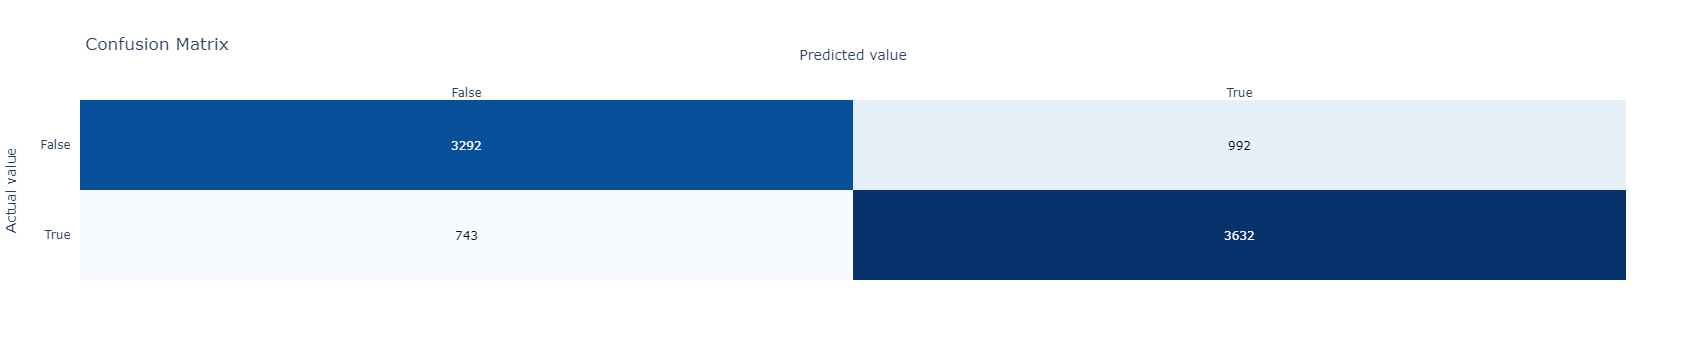

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The metric scores in all cv folds for confusion_matrix are [array([[336,  93],
       [ 85, 352]]), array([[340,  94],
       [ 72, 360]]), array([[332, 116],
       [ 70, 348]]), array([[327, 104],
       [ 89, 346]]), array([[329, 105],
       [ 69, 363]]), array([[315,  93],
       [ 71, 387]]), array([[343, 103],
       [ 74, 346]]), array([[315,  71],
       [ 83, 397]]), array([[339, 110],
       [ 63, 354]]), array([[316, 103],
       [ 67, 379]])]. 
 The final score is [[3292  992]
 [ 743 3632]], and the standard deviation is 131.15810830825518
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


cv_training(estimator=<class 'xgboost.sklearn.XGBClassifier'>,
            params={'enable_categorical': True,
                    'eval_metriceval_metric': 'accuracy_score', 'n_jobs': -1,
                    'random_state': 42})

In [76]:
base_XGBoost_ME.fit(df_train_ME, label="Transported", metric_list=["accuracy", "roc_auc", "f1", "confusion_matrix"], metric_opt_dir_list=["max", "max","max", "compr"])

<font size=4>We see the final accuracy score for baseline XGBClassifier without prior encoding is 0.7996308854743756, and the standard deviation is 0.012150303134042941.</font>

<a id="1.4.3"></a>
### 1.4.3 **Mixed OHE and CatBoost encoding**

In [77]:
df_train_Mixed = convert_object_to_category(df_train_Mixed)

In [79]:
base_XGBoost_Mixed= cv_training(estimator=xgb.XGBClassifier, params= base_params_XGB, n_splits = 10)

Starting the fitting process.
Starting training for fold 1


/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:38:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.




Completed training for fold 1
Starting training for fold 2
Completed training for fold 2
Starting training for fold 3


/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:38:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.


/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:38:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.




Completed training for fold 3
Starting training for fold 4
Completed training for fold 4
Starting training for fold 5


/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:38:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.


/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:38:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.




Completed training for fold 5
Starting training for fold 6


/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:38:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.




Completed training for fold 6
Starting training for fold 7
Completed training for fold 7
Starting training for fold 8


/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:38:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.


/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:38:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.




Completed training for fold 8
Starting training for fold 9
Completed training for fold 9
Starting training for fold 10


/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:38:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.


/home/garru/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[19:38:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metriceval_metric" } are not used.




Completed training for fold 10
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The metric scores in all cv folds for accuracy are [0.7886836027713626, 0.7967667436489607, 0.7956120092378753, 0.7979214780600462, 0.8025404157043879, 0.8013856812933026, 0.7886836027713626, 0.812933025404157, 0.7979214780600462, 0.7826589595375723]. 
 The final score is 0.7965106996489074, and the standard deviation is 0.008056470036950878
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The metric scores in all cv folds for roc_auc are [0.7886122268273298, 0.7968189964157706, 0.7969284005468216, 0.7977731551857481, 0.8026593701996927, 0.7999186574192996, 0.7894298526585523, 0.8117174006908462, 0.7999951931550529, 0.7807132078298746]. 
 The final score is 0.7964566460928988, and the standard deviation is

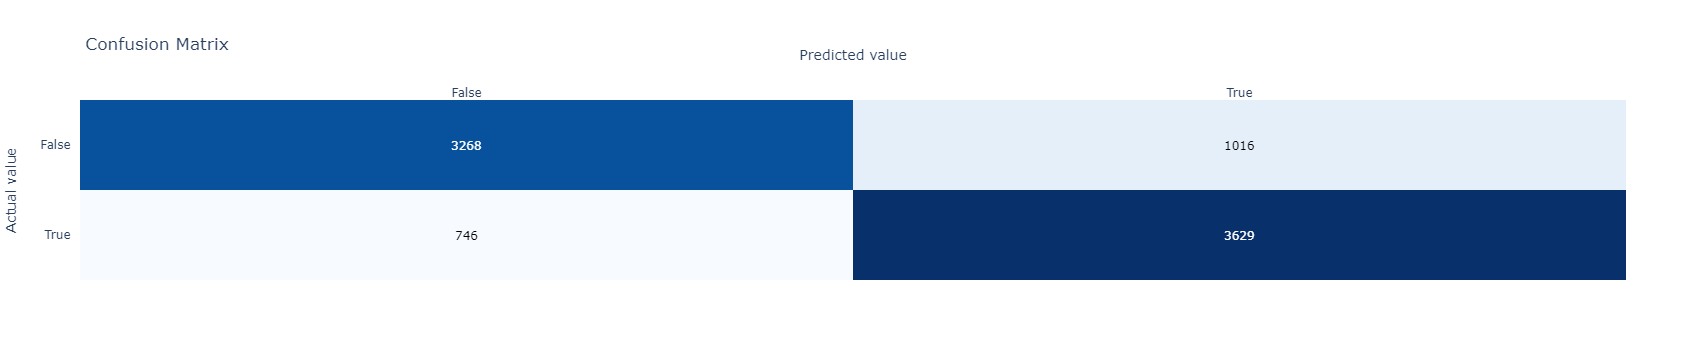

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The metric scores in all cv folds for confusion_matrix are [array([[335,  94],
       [ 89, 348]]), array([[336,  98],
       [ 78, 354]]), array([[340, 108],
       [ 69, 349]]), array([[330, 101],
       [ 74, 361]]), array([[326, 108],
       [ 63, 369]]), array([[316,  92],
       [ 80, 378]]), array([[341, 105],
       [ 78, 342]]), array([[309,  77],
       [ 85, 395]]), array([[334, 115],
       [ 60, 357]]), array([[301, 118],
       [ 70, 376]])]. 
 The final score is [[3268 1016]
 [ 746 3629]], and the standard deviation is 129.95883723317934
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


cv_training(estimator=<class 'xgboost.sklearn.XGBClassifier'>,
            params={'enable_categorical': True,
                    'eval_metriceval_metric': 'accuracy_score', 'n_jobs': -1,
                    'random_state': 42})

In [80]:
base_XGBoost_Mixed.fit(df_train_Mixed, label="Transported", metric_list=["accuracy", "roc_auc", "f1", "confusion_matrix"], metric_opt_dir_list=["max", "max","max", "compr"])

<font size=4>We see the final accuracy score for baseline XGBoostClassifier with Mixed OHE and CatBoost encoding is 0.7965106996489074, and the standard deviation is 0.008056470036950878.  </font>

<a id="1.5"></a>
## 1.5 **LGBMClassifier**

In [82]:
base_params_LGBM = {'random_state': 42, 'objective': 'binary', 'n_jobs': -1}

<a id="1.5.1"></a>
### 1.5.1 **No encoding**

In [83]:
base_fit_kwargs_LGBM_NE = get_fit_cat_params(lgb.LGBMClassifier.__name__, cat_col_list=get_cat_features(df_train_NE, 'Transported'))

In [84]:
base_LGBM_NE= cv_training(estimator=lgb.LGBMClassifier, params= base_params_LGBM, n_splits = 10)

Starting the fitting process.
Starting training for fold 1
[LightGBM] [Info] Number of positive: 3938, number of negative: 3855
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 7793, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505325 -> initscore=0.021302
[LightGBM] [Info] Start training from score 0.021302
Completed training for fold 1
Starting training for fold 2
[LightGBM] [Info] Number of positive: 3943, number of negative: 3850
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 7793, 

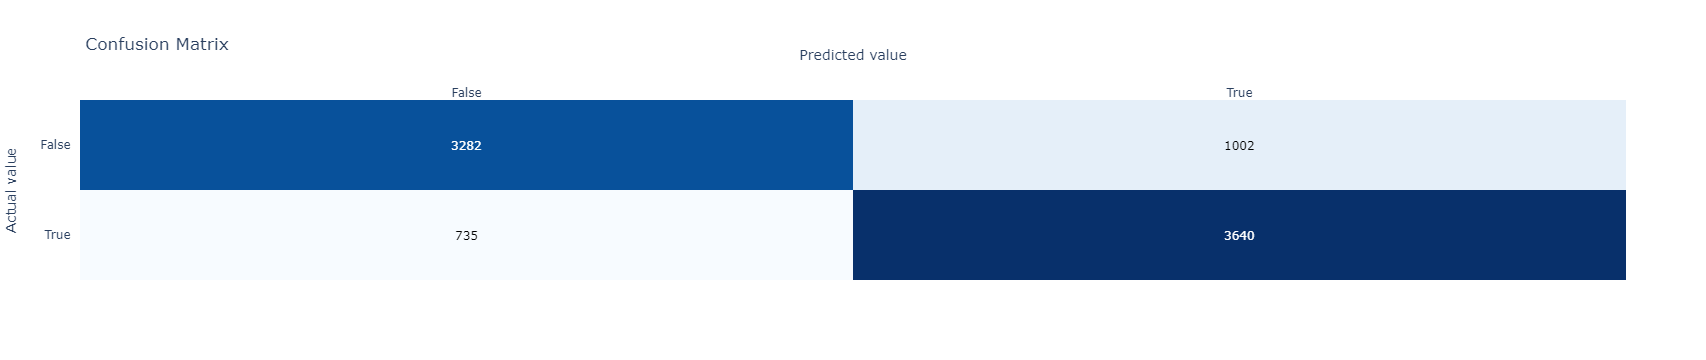

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The metric scores in all cv folds for confusion_matrix are [array([[342,  87],
       [ 85, 352]]), array([[338,  96],
       [ 71, 361]]), array([[330, 118],
       [ 70, 348]]), array([[333,  98],
       [ 81, 354]]), array([[324, 110],
       [ 56, 376]]), array([[309,  99],
       [ 81, 377]]), array([[349,  97],
       [ 73, 347]]), array([[311,  75],
       [ 84, 396]]), array([[340, 109],
       [ 66, 351]]), array([[306, 113],
       [ 68, 378]])]. 
 The final score is [[3282 1002]
 [ 735 3640]], and the standard deviation is 131.23471101427396
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


cv_training(estimator=<class 'lightgbm.sklearn.LGBMClassifier'>,
            params={'n_jobs': -1, 'objective': 'binary', 'random_state': 42})

In [85]:
base_LGBM_NE.fit(df_train_NE, label="Transported", fit_kwargs=base_fit_kwargs_LGBM_NE, metric_list=["accuracy", "roc_auc", "f1", "confusion_matrix"], metric_opt_dir_list=["max", "max","max", "compr"])

<font size=4>We see the final accuracy score for baseline LGBMClassifier without prior encoding is 0.7993984701437745, and the standard deviation is 0.009432098244708195.</font>

<a id="1.5.2"></a>
### 1.5.2 **MEstimate**

In [86]:
base_LGBM_ME= cv_training(estimator=lgb.LGBMClassifier, params= base_params_LGBM, n_splits = 10)

Starting the fitting process.
Starting training for fold 1
[LightGBM] [Info] Number of positive: 3938, number of negative: 3855
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1631
[LightGBM] [Info] Number of data points in the train set: 7793, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505325 -> initscore=0.021302
[LightGBM] [Info] Start training from score 0.021302
Completed training for fold 1
Starting training for fold 2
[LightGBM] [Info] Number of positive: 3943, number of negative: 3850
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1631


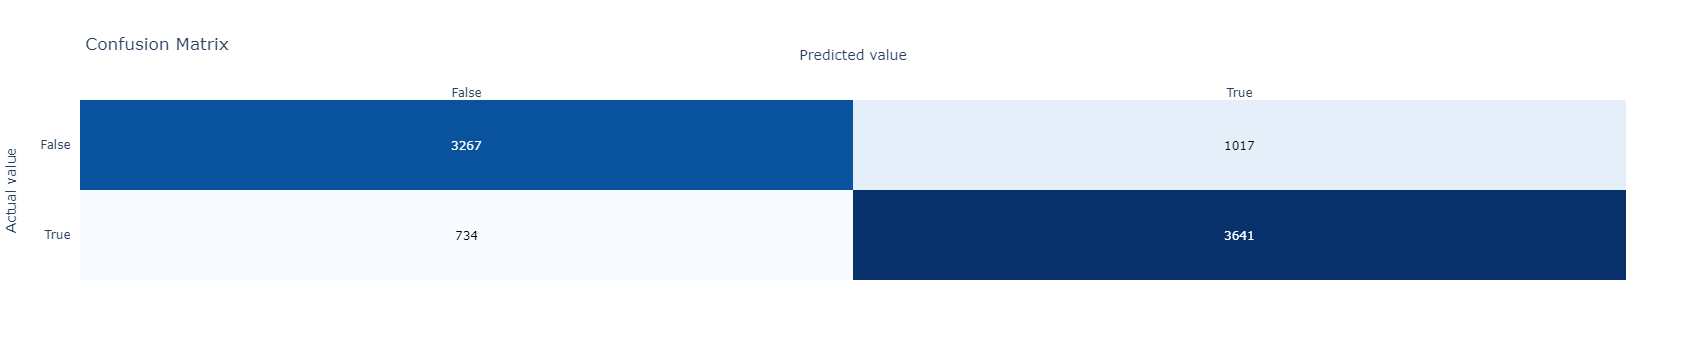

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The metric scores in all cv folds for confusion_matrix are [array([[335,  94],
       [ 86, 351]]), array([[341,  93],
       [ 80, 352]]), array([[338, 110],
       [ 72, 346]]), array([[330, 101],
       [ 82, 353]]), array([[330, 104],
       [ 63, 369]]), array([[307, 101],
       [ 69, 389]]), array([[345, 101],
       [ 73, 347]]), array([[308,  78],
       [ 85, 395]]), array([[334, 115],
       [ 64, 353]]), array([[299, 120],
       [ 60, 386]])]. 
 The final score is [[3267 1017]
 [ 734 3641]], and the standard deviation is 130.72260468258733
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


cv_training(estimator=<class 'lightgbm.sklearn.LGBMClassifier'>,
            params={'n_jobs': -1, 'objective': 'binary', 'random_state': 42})

In [87]:
base_LGBM_ME.fit(df_train_ME, label="Transported",  metric_list=["accuracy", "roc_auc", "f1", "confusion_matrix"], metric_opt_dir_list=["max", "max","max", "compr"])

<font size=4>We see the final accuracy score for baseline LGBMClassifier with MEstimate encoding is 0.796189376443418, and the standard deviation is 0.007474426266443869.</font>

<a id="1.5.3"></a>
### 1.5.3 **Mixed OHE and CatBoost encoding**

In [89]:
base_fit_kwargs_LGBM_Mixed = get_fit_cat_params(lgb.LGBMClassifier.__name__, cat_col_list=get_cat_features(df_train_Mixed, 'Transported'))

In [91]:
base_LGBM_Mixed= cv_training(estimator=lgb.LGBMClassifier, params= base_params_LGBM, n_splits = 10)

Starting the fitting process.
Starting training for fold 1
[LightGBM] [Info] Number of positive: 3938, number of negative: 3855
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1345
[LightGBM] [Info] Number of data points in the train set: 7793, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505325 -> initscore=0.021302
[LightGBM] [Info] Start training from score 0.021302
Completed training for fold 1
Starting training for fold 2
[LightGBM] [Info] Number of positive: 3943, number of negative: 3850
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Number of data points in the train set: 7793, n

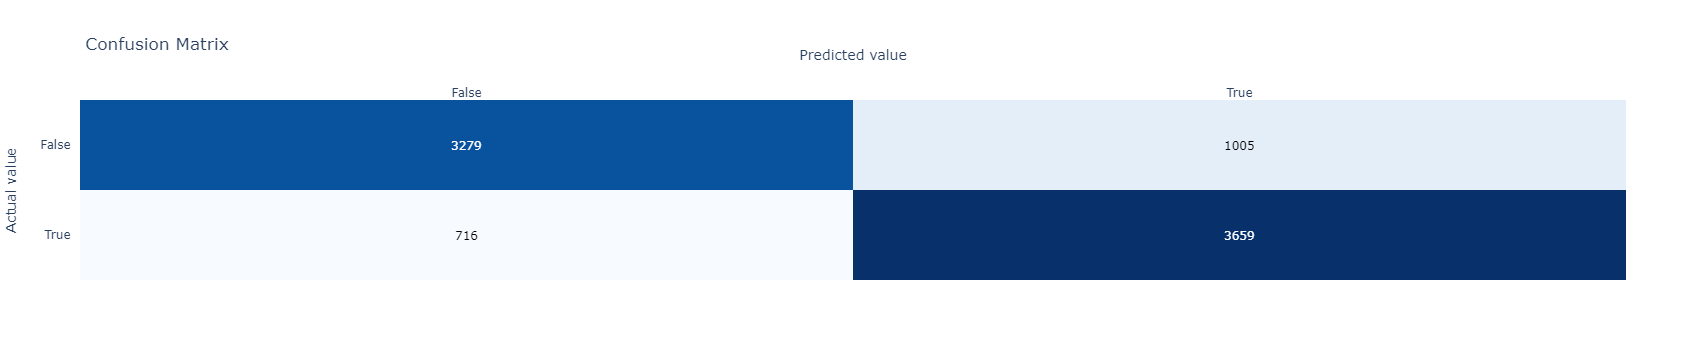

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The metric scores in all cv folds for confusion_matrix are [array([[337,  92],
       [ 89, 348]]), array([[336,  98],
       [ 79, 353]]), array([[343, 105],
       [ 68, 350]]), array([[328, 103],
       [ 72, 363]]), array([[333, 101],
       [ 60, 372]]), array([[304, 104],
       [ 68, 390]]), array([[345, 101],
       [ 68, 352]]), array([[310,  76],
       [ 82, 398]]), array([[332, 117],
       [ 61, 356]]), array([[311, 108],
       [ 69, 377]])]. 
 The final score is [[3279 1005]
 [ 716 3659]], and the standard deviation is 132.12947958347524
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


cv_training(estimator=<class 'lightgbm.sklearn.LGBMClassifier'>,
            params={'n_jobs': -1, 'objective': 'binary', 'random_state': 42})

In [92]:
base_LGBM_Mixed.fit(df_train_Mixed, label="Transported", fit_kwargs=base_fit_kwargs_LGBM_Mixed, metric_list=["accuracy", "roc_auc", "f1", "confusion_matrix"], metric_opt_dir_list=["max", "max","max", "compr"])

<font size=4>We see the final accuracy score for baseline LGBMClassifier with Mixed OHE and CatBoost encoding is0.7990762124711317, and the standard deviation is 0.008205466689675358.  </font>

<a id="2"></a>
# 2 **Hyperparameter tuning with Optuna**

<a id="2.0"></a>
## 2.0 **Hyperparameter tuning CV model with Optuna: class definition**

In [6]:
class HPT_Optuna_CV:
    """
    A class for conducting hyperparameter tuning using Optuna with a focus on cross-validation.

    This class provides functionality to perform both non-cross-validated and cross-validated
    model evaluations within Optuna trials to efficiently use computational resources. It first
    evaluates simpler models and proceeds to more computationally expensive cross-validated models
    if initial results are promising.

    Attributes:
        random_state (int): Controls the randomness of the trial sampling and other stochastic elements, defaults to 42.
        prune (bool): Flag to determine whether to use pruning, initialized as True.
        direction (str or None): The direction of optimization ('minimize' or 'maximize'), not set initially.

    """

    def __init__(self, cfg: HPT_Config, random_state: int = 42, prune: bool = False, cat_feat_fit: bool = True):
        """Initializes the hyperparameter tuning class with the specified random state."""
        self.random_state = random_state
        self.cfg = cfg
        self.prune = prune
        self.direction = None
        self.cat_feat_fit = cat_feat_fit

    def instantiate_cv_model(self, trial: Trial, model=None, params: dict = {}):
        """
        Instantiates a cross-validation model using specified parameters.

        Args:
            trial (optuna.trial._trial.Trial): The trial instance from Optuna.
            model (class, optional): The model class to be instantiated for CV.
            params (dict, optional): Parameters to initialize the model.

        Returns:
            object: The instantiated model ready for cross-validation.
        """
        return cv_training(estimator=model, params=params, random_state=self.random_state)

    def obj_function(
        self,
        trial: Trial,
        model=None,
        fit_kwargs: dict = {},
        predict_kwargs: dict = {},
        metric_name: str = None,
        metric_list: list[str] = [],
        metric_opt_dir_list: list[str] = [],
        metric_kwargs: dict = {},
        df: pd.DataFrame = None,
        label: str = None,
    ) -> float:
        """
        Objective function for Optuna optimization, evaluating model performance using both non-CV and CV methods.
        It first evaluates the model on a split dataset and if the results are promising, proceeds to a cross-validated evaluation.

        Args:
            trial (optuna.trial._trial.Trial): The trial instance from Optuna.
            model (class): The model class to be used for the trials.
            fit_kwargs (dict): Keyword arguments for the model's fit method.
            predict_kwargs (dict): Keyword arguments for the model's predict method.
            metric_name (str): The name of the metric to optimize.
            metric_list (list of str): List of metrics to be evaluated.
            metric_opt_dir_list (list of str): Directions ('minimize' or 'maximize') for each metric.
            metric_kwargs (dict): Additional keyword arguments for the metric function.
            df (pd.DataFrame): The dataframe containing features and target.
            label (str): The column name of the target variable in `df`.

        Returns:
            float: The evaluation metric value for the cross-validated model.

        Raises:
            ValueError: If required parameters are not provided or if initial non-CV evaluation fails to meet expectations.
        """
        if df is None or df.empty:
            raise ValueError("Training set must be provided.")
        if not label:
            raise ValueError("The name of thelabel(target) must be specified.")
        if not metric_name:
            raise ValueError("The name of the metric to be optimized must be specified.")
        if metric_name not in metric_list:
            raise ValueError(f"The metric name '{metric_name}' is not in the list of metrics to be evaluated.")
        if not model:
            raise ValueError("The class of the model must be specified.")

        # Define the search space for the hyperparameters
        params = {
            k: getattr(trial, f'suggest_{v["type"]}')(name=v["name"], **{key: val for key, val in v.items() if key not in ['type', 'name']})
            for k, v in self.cfg.hyperparameters.items()
        }
        # Initialize features and label
        X = df.drop(columns=label)
        Y = df[label]
        cat_features = get_cat_features(X, label)
        cat_fit_kwargs = get_fit_cat_params(model.__name__, cat_col_list=cat_features)
        # Pruning a trial based on the score of the model without cv. If the non-cv score is promising, the trial won't be killed and we proceed to train the model with cv.
        if self.prune is True:
            # Intialize the model, the training and the validation set without cv to be evaluated for pruning
            model_prune = model(**params, random_state=self.random_state)
            X_train, X_val, Y_train, Y_val = train_test_split(
                X, Y, test_size=0.2, random_state=self.random_state, stratify=df[label]
            )
            # If a boosting tree model has native support warm_start, we prune the model by adding a single tree in each iteration.

            if params.get("warm_start") is True and params.get("n_estimator", 0) > 100:
                n_estimators = model.get_params().get("n_estimators")
                min_estimators = 100

                for num_estimator in range(min_estimators, n_estimators):
                    model_prune.set_params(n_estimators=num_estimator)
                    model_prune.fit(X_train, Y_train, **fit_kwargs, **cat_fit_kwargs)
                    y_pred = model_prune.predict(X_val, **predict_kwargs)
                    metric = get_single_metric(metric_name)
                    if (
                        metric_name == "roc_auc"
                        or metric_name == "average_precision"
                        or metric_name == "precision_recall_curve"
                    ):
                        y_pred = model_prune.predict_proba(X_val, **predict_kwargs)[:, 1]
                    score = metric(Y_val, y_pred, **metric_kwargs)
                    trial.report(score, num_estimator)

                    if trial.should_prune():
                        raise optuna.TrialPruned()
            # In other cases, if the pruner is still SuccessiveHalvingPruner, we run an Asynchronous SHA (ASHA) implementation to prune a trial
            elif self.pruner == SuccessiveHalvingPruner:
                n_samples_list = generate_sample_numbers(Y_train, self.base, self.n_rungs)
                for n_samples in n_samples_list:
                    _, X_train_sample, _, Y_train_sample = train_test_split(
                        X_train, Y_train, test_size=n_samples, random_state=self.random_state, stratify=Y_train
                    )
                    model_prune.fit(X_train_sample, Y_train_sample.values.ravel(), **fit_kwargs, **cat_fit_kwargs)
                    y_pred = model_prune.predict(X_val, **predict_kwargs)
                    metric = get_single_metric(metric_name)
                    if (
                        metric_name == "roc_auc"
                        or metric_name == "average_precision"
                        or metric_name == "precision_recall_curve"
                    ):
                        y_pred = model_prune.predict_proba(X_val, **predict_kwargs)[:, 1]
                    score = metric(Y_val, y_pred, **metric_kwargs)
                    trial.report(score, n_samples)

                    if trial.should_prune():
                        raise optuna.TrialPruned()

        if self.cat_feat_fit:
            fit_kwargs = {**fit_kwargs, **cat_fit_kwargs}
        else:
            params = {**params, **cat_fit_kwargs}
        model_cv = self.instantiate_cv_model(trial, model=model, params=params)
        model_cv.fit(
            df,
            label,
            fit_kwargs=fit_kwargs,
            predict_kwargs=predict_kwargs,
            metric_list=metric_list,
            metric_opt_dir_list=metric_opt_dir_list,
            metric_kwargs=metric_kwargs,
        )
        score_cv = model_cv.metrics_stats[metric_name]["final"]
        return score_cv

    def launch_study(
        self,
        study_name: str = None,
        pruner: pruners.BasePruner = SuccessiveHalvingPruner,
        pruner_kwargs: dict = {"reduction_factor": 2},
        n_rungs: int = 4,
        sampler: samplers.BaseSampler = TPESampler,
        sampler_kwargs: dict = {},
        model=None,
        model_name: str = None,
        encoding: str = None,
        fit_kwargs: dict = {},
        predict_kwargs: dict = {},
        metric_name: str = None,
        metric_list: list[str] = [],
        metric_opt_dir_list: list[str] = [],
        metric_kwargs: dict = {},
        df: pd.DataFrame = None,
        label: str = None,
        n_trials: int = 100,
        artifact_directory: str = None,
        if_callback: bool = True,
    ):
        """
        Launches an Optuna optimization study.

        Args:
            study_name (str, optional): Name of the study.
            pruner (optuna.pruners.BasePruner, optional): The pruning strategy to use.
            pruner_kwargs (dict, optional): Keyword arguments to initialize the pruner.
            model (class, optional): The model class to be used.
            model_name (str, optional): Name of the model.
            encoding (str, optional): Encoding type to use.
            fit_kwargs (dict, optional): Additional keyword arguments for fitting the model.
            predict_kwargs (dict, optional): Additional keyword arguments for model prediction.
            metric_name (str, optional): Name of the primary metric for optimization.
            metric_list (list of str, optional): List of all metrics to consider.
            metric_opt_dir_list (list of str, optional): Directions of optimization for each metric.
            metric_kwargs (dict, optional): Additional keyword arguments for metrics.
            df (pd.DataFrame, optional): DataFrame containing the training data.
            label (str, optional): Name of the label column in `df`.
            n_trials (int, optional): Number of trials to conduct, defaults to 100.
            artifact_directory (str, optional): Directory to save artifacts.
            if_callback (bool, optional): Flag to determine whether to use the callback function.

        Returns:
            optuna.study.Study: The completed Optuna study.
        """
        # Check if the reduction factor (base) is an integer greater than or equal to 2 if the pruner is Successive Halving
        self.pruner = pruner
        if pruner == SuccessiveHalvingPruner and ("reduction_factor" in pruner_kwargs):
            if pruner_kwargs["reduction_factor"] < 2 or pruner_kwargs["reduction_factor"] % 1 != 0:
                raise ValueError(
                    "The reduction factor for the Successive Halving Pruner must be an integer greater than or equal to 2"
                )
            else:
                self.base = pruner_kwargs["reduction_factor"]
                self.n_rungs = n_rungs

        self.direction = metric_opt_dir_list[metric_list.index(metric_name)]
        # Create the study according to the direction of the metric optimization
        if self.direction == "min":
            study = create_study(
                direction="minimize",
                pruner=pruner(**pruner_kwargs),
                sampler=sampler(seed=self.random_state, **sampler_kwargs),
            )
        elif self.direction == "max":
            study = create_study(
                direction="maximize",
                pruner=pruner(**pruner_kwargs),
                sampler=sampler(seed=self.random_state, **sampler_kwargs),
            )
        else:
            raise ValueError(
                "The direction of the metric optimization can either be 'min' for minimize and 'max' for maximize"
            )

        # Create call back to log the best trial
        artifact_directory = Path(artifact_directory) / f"{model_name}_{encoding}"
        if if_callback:
            def callback(study, trial):
                log_best_trial(
                    study=study,
                    trial=trial,
                    df=df,
                    label=label,
                    model=model,
                    model_name=model_name,
                    encoding=encoding,
                    fit_kwargs=fit_kwargs,
                    predict_kwargs=predict_kwargs,
                    metric_list=metric_list,
                    metric_opt_dir_list=metric_opt_dir_list,
                    metric_kwargs=metric_kwargs,
                    metric_obj=metric_name,
                    random_state=self.random_state,
                    directory=artifact_directory,
                    cat_feat_fit=self.cat_feat_fit
                )
        else:
            callback = None
        # Optimize the objective function
        study.optimize(
            lambda trial: self.obj_function(
                trial=trial,
                model=model,
                fit_kwargs=fit_kwargs,
                predict_kwargs=predict_kwargs,
                metric_name=metric_name,
                metric_list=metric_list,
                metric_opt_dir_list=metric_opt_dir_list,
                metric_kwargs=metric_kwargs,
                df=df,
                label=label
            ),
            callbacks=[callback],
            n_trials=n_trials,
        )
        return study